In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matrixprofile as mp
import random
import time
import os
from matplotlib.patches import Rectangle

In [2]:
data_paths = {  'd_ntp'     : 'ntp_ddos_14_minutes.csv',
                'd_udp'     : 'udp_ddos_2_minutes.csv',
                'd_syn'     : 'syn_ddos_3_minutes.csv',
                'd_ldap'    : 'ldap_ddos_9_minutes.csv',
                'd_udp_lag' : 'udp_lag_ddos_7_minutes.csv',
             
                'b_ntp'     : 'ntp_benign_30_minutes.csv',
                'b_syn'     : 'syn_benign_1_minutes.csv',
                'b_ldap'    : 'ldap_benign_5_minutes.csv',
                'b_udp_lag' : 'udp_lag_benign_7_minutes.csv'}

dataset_dict = {}

In [3]:
def upload_dataset_with_time(path:str):
    startingT = time.perf_counter()
    if 'pkl' in path:
        veriseti = pd.read_pickle(path)
    else:
        veriseti = pd.read_csv(path, low_memory=True)
    endingT = time.perf_counter()
    print(f"Dataset is loaded in {endingT - startingT} seconds")
    return veriseti

In [4]:
for data_name, path in data_paths.items():
    data = upload_dataset_with_time(path)
    dataset_dict[data_name] = data

Dataset is loaded in 0.015049099999941973 seconds
Dataset is loaded in 0.00408289999995759 seconds
Dataset is loaded in 0.004275900000038746 seconds
Dataset is loaded in 0.006898800000044503 seconds
Dataset is loaded in 0.004835699999830467 seconds
Dataset is loaded in 0.011301600000024337 seconds
Dataset is loaded in 0.0026422000000820844 seconds
Dataset is loaded in 0.003763800000115225 seconds
Dataset is loaded in 0.004794700000047669 seconds


## 1. Veriseti İşlemleri

CiC veriseti 2 farklı atak tipini içeriyor.<br> 
1- Reflection Attacks<br>
2- Exploitation Attacks<br><br>

Explotitation : Syn Flood , UDP Flood<br>
Reflection : NTP <br>
Ataklarını alarak işlemlere başladık. İlk olarak bu veriseti flow based kaydedilmiş.<br>
Matrix Profile ile incelemek için, data paketlerini bir time series'e dönüştürme işlemi gerçekleştirdim.<br>
Bunu yaparken, ilk olarak saniye cinsinden flowları grupladım.<br>

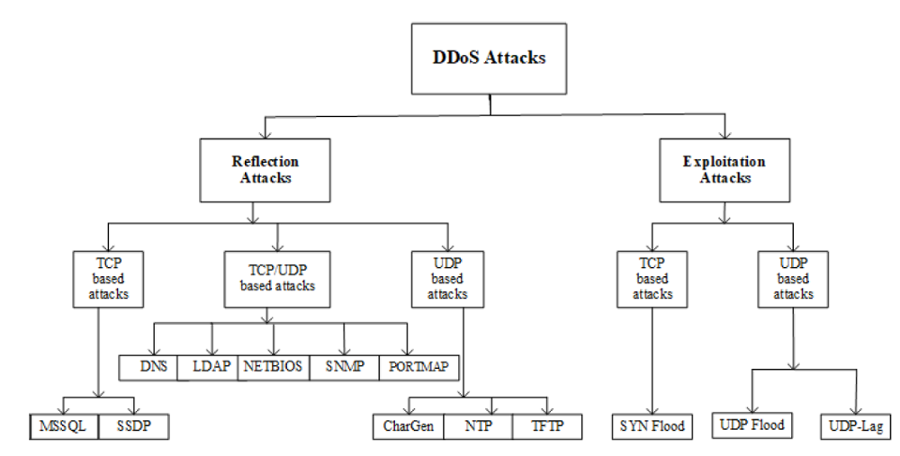

In [5]:
from IPython.display import Image
Image('gorseller/ddos_attacks.png',  width=700, height=450)

#### İşlenmeden önceki Syn Flood veriseti

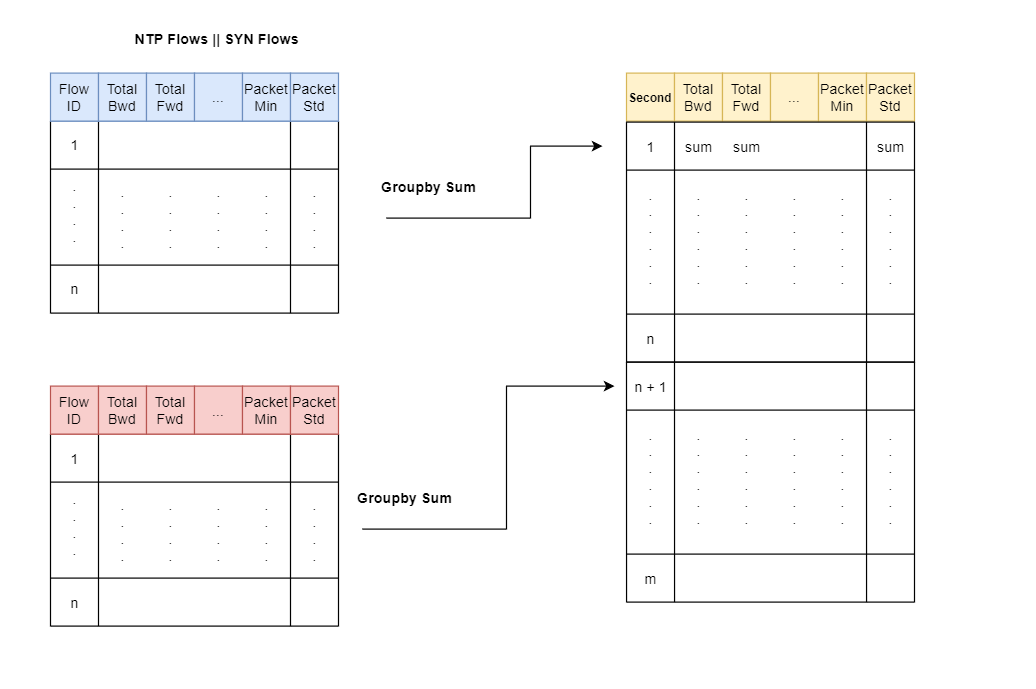

In [6]:
Image('gorseller/data_process_seconds.png', width=800, height=400)

In [7]:
temp_syn_all = pd.read_pickle("../verisetleri/syn.pkl")
print(f"row data sayisi: {temp_syn_all.shape[0]}\nFeature sayisi : {temp_syn_all.shape[1]}")
display(temp_syn_all.iloc[:3,1:12])
del temp_syn_all

row data sayisi: 1582681
Feature sayisi : 88


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets
0,172.16.0.5-192.168.50.1-53058-53058-6,172.16.0.5,53058,192.168.50.1,53058,6,2018-12-01 13:30:30.741451,115799309,19,2,0.0
1,172.16.0.5-192.168.50.1-32237-32237-6,172.16.0.5,32237,192.168.50.1,32237,6,2018-12-01 13:30:30.741452,113973933,16,0,0.0
2,172.16.0.5-192.168.50.1-60495-9840-6,172.16.0.5,60495,192.168.50.1,9840,6,2018-12-01 13:30:30.741501,112,2,2,0.0


In [8]:
display(dataset_dict["d_syn"].iloc[:3,:12])

,Date_Second,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min
0,13:30:30,109879284729,22313,2178,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,13:30:31,414731759563,67874,7162,112.0,0.0,56.0,0.0,6.222222,18.109327,0.0,0.0
2,13:30:32,385882968598,64558,6852,168.0,0.0,84.0,28.0,34.222222,18.109327,0.0,0.0


In [9]:
df_duration_list = [(key, len(value)) for key, value in dataset_dict.items()]
display(df_duration_list)

[('d_ntp', 840),
 ('d_udp', 120),
 ('d_syn', 180),
 ('d_ldap', 540),
 ('d_udp_lag', 420),
 ('b_ntp', 1800),
 ('b_syn', 60),
 ('b_ldap', 300),
 ('b_udp_lag', 420)]

In [10]:
syn_df = pd.concat([dataset_dict["b_ldap"], dataset_dict["b_ldap"] , dataset_dict["d_syn"],
                    dataset_dict["d_syn"], dataset_dict["b_udp_lag"],
                    dataset_dict["d_syn"], dataset_dict["b_ntp"].iloc[:5*60, :]], axis=0).reset_index(drop=True)

In [11]:
def plot_ddos(df: pd.DataFrame, attack_list:list[tuple]):
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='lightgreen', lw=3),
                    Line2D([0], [0], color='red', lw=3),
                    Line2D([0], [0], color='blue', lw=3),
                    Line2D([0], [0], color='black', lw=3),
                    Line2D([0], [0], color='brown', lw=3)]
    
    attack_color_dict = {'syn' : 'lightgreen', 'ntp' : 'red', 'udp' : 'blue', 'udp_lag' : 'black', 'ldap' : 'brown'}
    
    total_duration = len(df) / 60
    print(f"Total Duration Of Traffic is: {total_duration} minutes")
    xAxis = list(range(len(df)))
    yAxis = df["Label"].to_list()
    fig = plt.figure(figsize=(25,15))
    ax = fig.add_subplot()
    ax.plot(xAxis, yAxis)
    
    legend_custom_lines = []
    legend_custom_names = []
    for attack in attack_list:
        face_color = attack_color_dict[attack[0]]
        attack_duration = attack[1]
        duration_before_attack = attack[2]
        
        attack_index = list(attack_color_dict.keys()).index(attack[0])
        if attack[0] not in legend_custom_names:
            legend_custom_lines.append(custom_lines[attack_index])
            legend_custom_names.append(attack[0])
        
        rect = Rectangle((duration_before_attack * 60, 0), attack_duration * 60, 1, facecolor=face_color)
        ax.add_patch(rect)

    
    ax.legend(legend_custom_lines, legend_custom_names,  prop={'size': 20})
    
    plt.ylabel('Label')
    plt.xlabel('Seconds')
    plt.title('Network Traffic')
    plt.show()

Total Duration Of Traffic is: 31.0 minutes


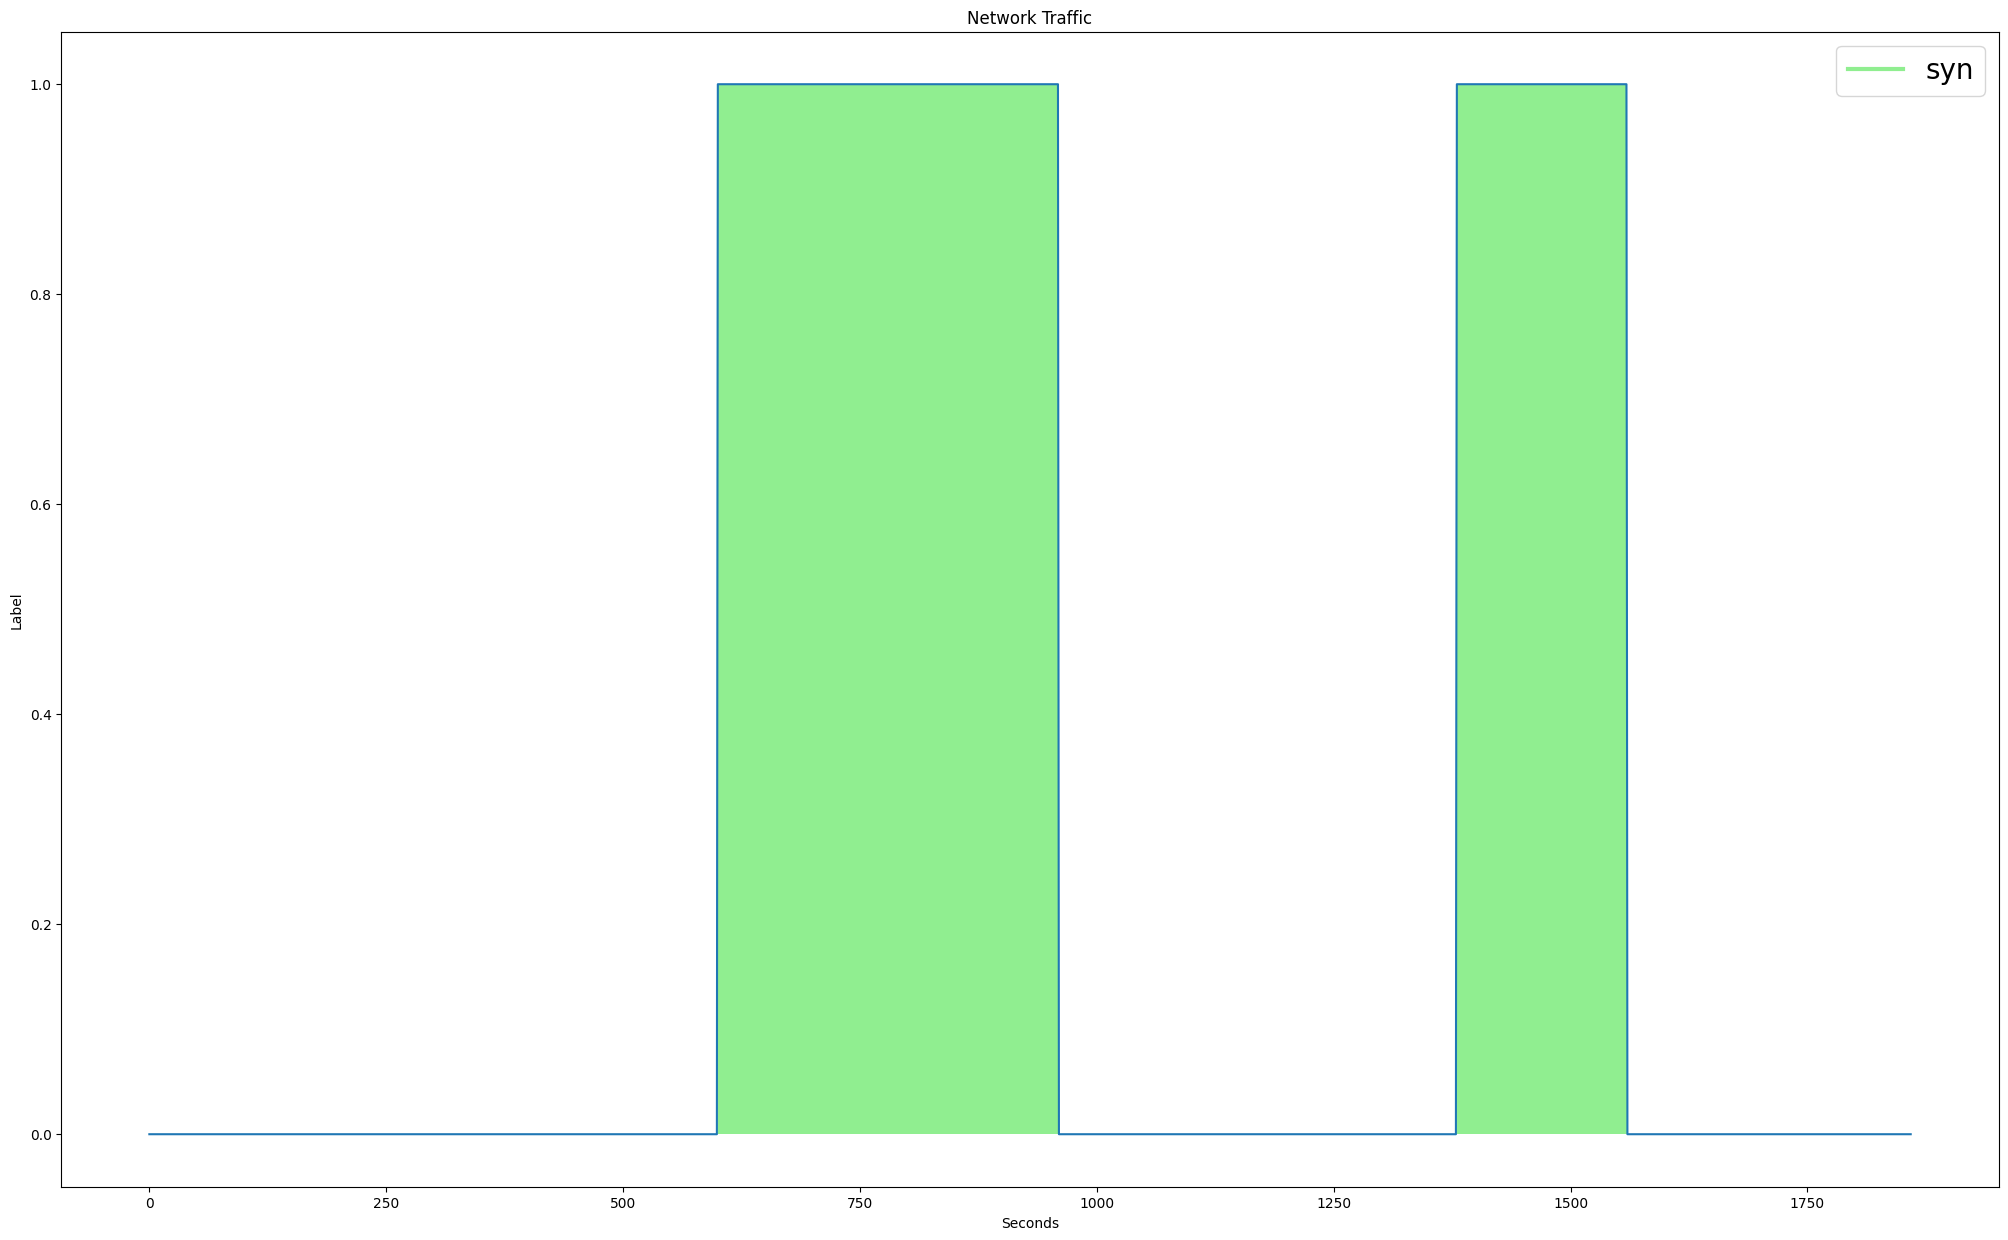

In [12]:
plot_ddos(syn_df, [('syn', 6, 10), ('syn', 3, 23)])

## 1. Sadece SYN Flood olan 30 dakikalık veriseti

### Referans Makalede kullanılan yöntem

Selected Feature : <b>Fwd Packets Length Std</b><br>
Threshold : <b>0.5</b><br>
Accuracy  : <b>0.93</b>

#### 1. Syn Flood

In [13]:
from mp_utils import *
import warnings
warnings.filterwarnings('ignore')

In [14]:
f1_score_list = []
MatrixProfileManager.global_df = syn_df.copy()
for col in syn_df.columns[1:-1]:
    threshold_MP_syn = ThresholdMatrixProfile(pd.DataFrame(syn_df[col]), window_size=10, threshold=2)
    cost, f1_score = threshold_MP_syn.calculate_cost()
    f1_score_list.append((f1_score, col))
    
sorted(f1_score_list, key=lambda x:x[0], reverse=True)[:5]

[(0.7843137254901961, ' Bwd Packet Length Min'),
 (0.7786589762076424, 'Fwd PSH Flags'),
 (0.7786589762076424, ' RST Flag Count'),
 (0.617283950617284, ' Total Length of Bwd Packets'),
 (0.6126295947219604, 'Bwd Packet Length Max')]

In [15]:
f1_score_list = []
for col in syn_df.columns[1:-1]:
    isolation_MP_syn = IsolationMatrixProfile(pd.DataFrame(syn_df[col]), window_size=10, n_estimators = 100, contamination='auto')
    cost, f1_score = isolation_MP_syn.calculate_cost()
    f1_score_list.append((f1_score, col))
    
sorted(f1_score_list, key=lambda x:x[0], reverse=True)[:5]

[(0.7943485086342229, ' SYN Flag Count'),
 (0.6334519572953736, ' RST Flag Count'),
 (0.6308328411104548, 'Fwd PSH Flags'),
 (0.5686900958466453, ' Bwd Packet Length Min'),
 (0.45169385194479295, 'Flow Bytes/s')]

#### 2. Syn + NTP

In [17]:
ntp_df = pd.concat([dataset_dict["b_ldap"], dataset_dict["b_ldap"] , dataset_dict["d_ntp"][:5*60],
                    dataset_dict["b_udp_lag"],
                    dataset_dict["d_syn"], dataset_dict["b_ntp"].iloc[:5*60, :]], axis=0).reset_index(drop=True)

Total Duration Of Traffic is: 30.0 minutes


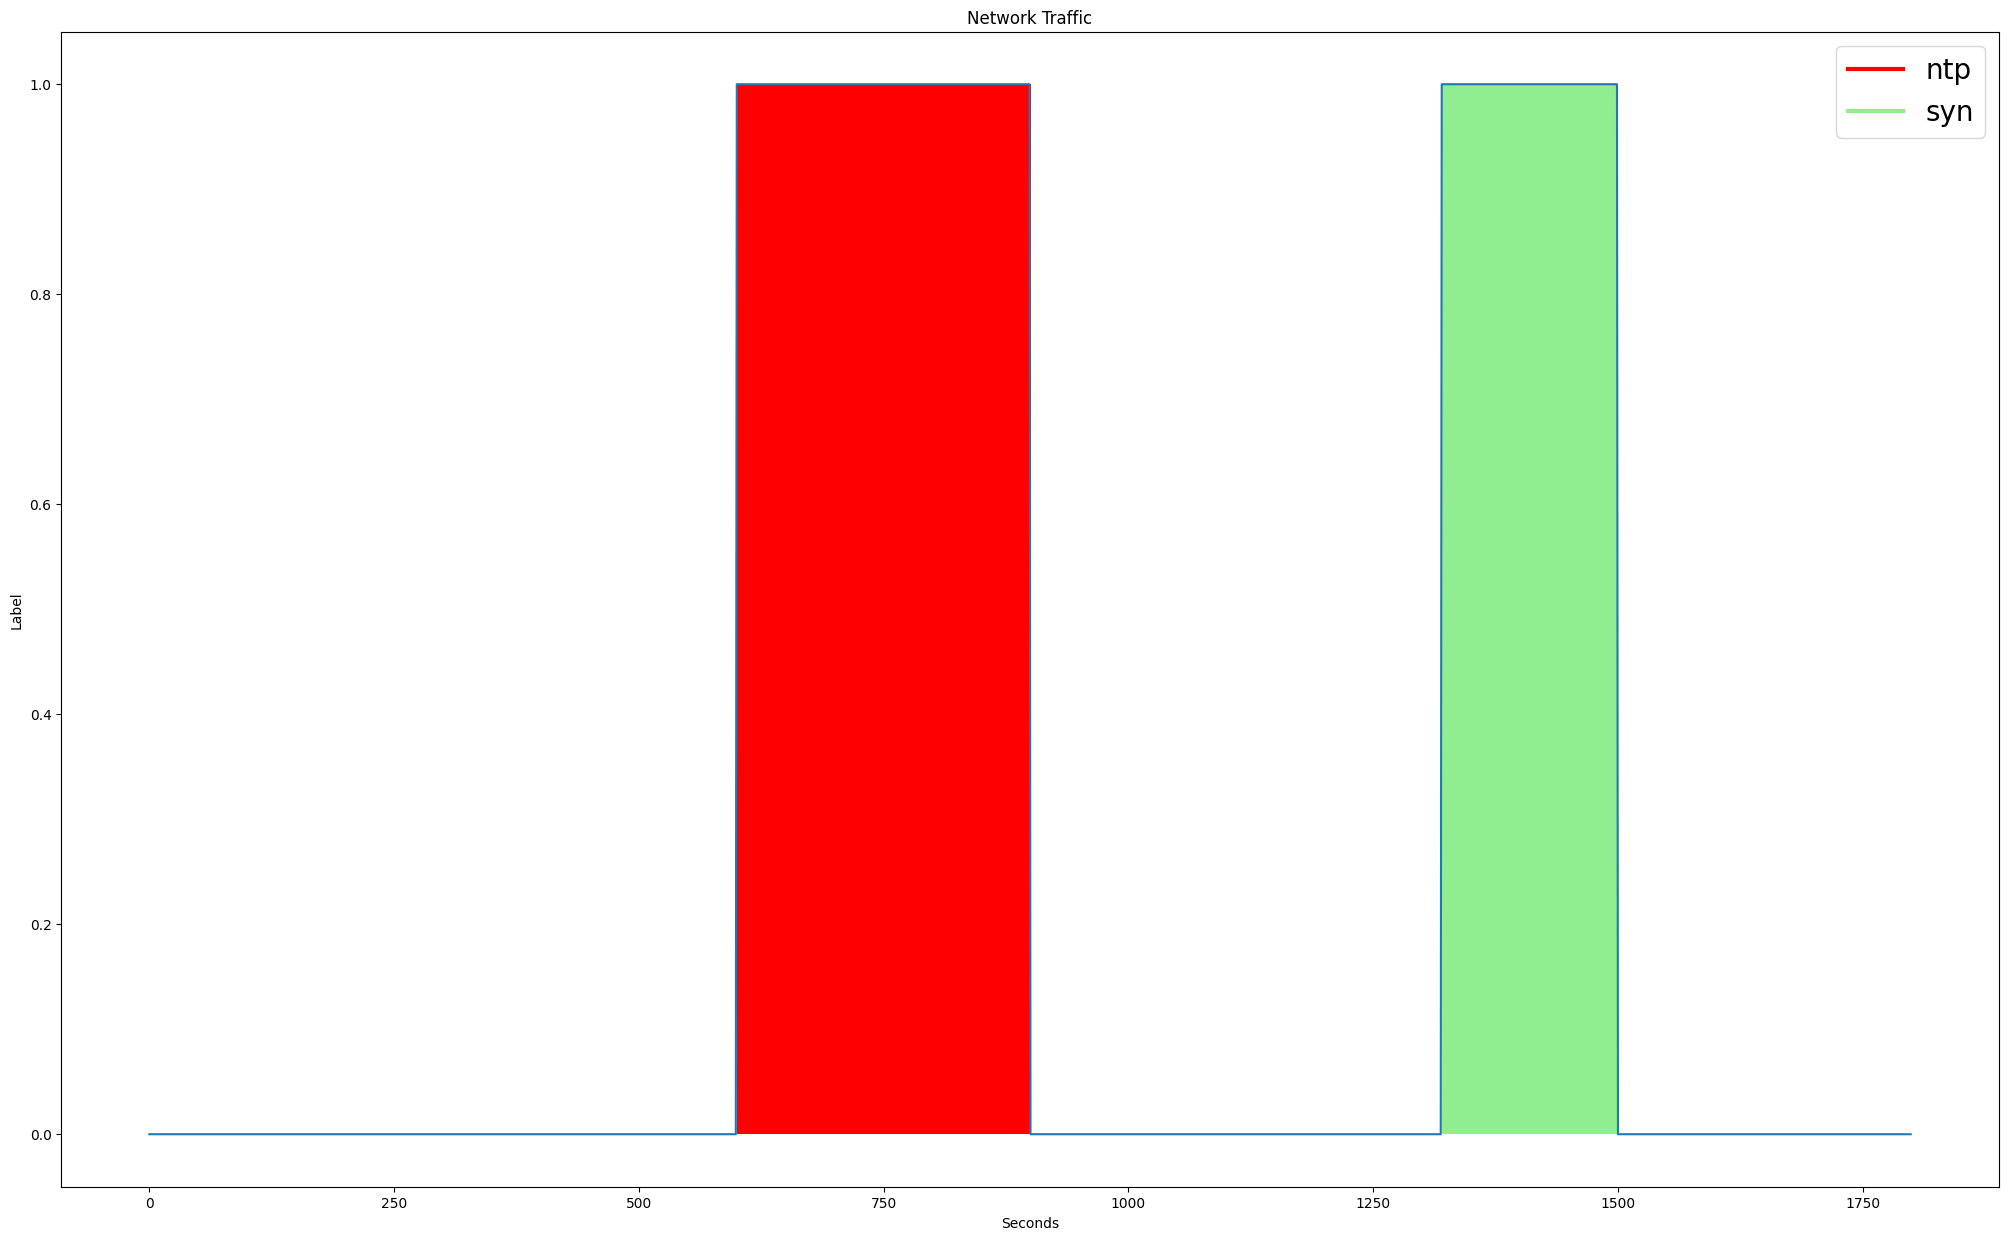

In [18]:
plot_ddos(ntp_df, [('ntp', 5, 10), ('syn', 3, 22)])

In [19]:
f1_score_list = []
MatrixProfileManager.global_df = ntp_df.copy()
for col in ntp_df.columns[1:-1]:
    threshold_MP_ntp = ThresholdMatrixProfile(pd.DataFrame(ntp_df[col]), window_size=10, threshold=2)
    cost, f1_score = threshold_MP_ntp.calculate_cost()
    f1_score_list.append((f1_score, col))
    
sorted(f1_score_list, key=lambda x:x[0], reverse=True)[:5]

[(0.7455429497568883, ' Bwd Packet Length Min'),
 (0.724177071509648, ' Flow IAT Min'),
 (0.627054361567636, 'Fwd Packets/s'),
 (0.6269982238010657, 'Fwd PSH Flags'),
 (0.6269982238010657, ' RST Flag Count')]

In [135]:
f1_score_list = []
MatrixProfileManager.global_df = ntp_df.copy()
for col in ntp_df.columns[1:-1]:
    isolation_MP_ntp = IsolationMatrixProfile(pd.DataFrame(ntp_df[col]), window_size=60)
    cost, f1_score = isolation_MP_ntp.calculate_cost()
    f1_score_list.append((f1_score, col))
    
sorted(f1_score_list, key=lambda x:x[0], reverse=True)[:5]

[(0.681044267877412, ' Fwd Header Length'),
 (0.6341463414634145, 'Fwd Packets/s'),
 (0.606845513413506, ' Fwd IAT Std'),
 (0.6050895381715364, ' Flow IAT Std'),
 (0.58984375, ' Fwd IAT Max')]

In [21]:
from GeneticAlgorithmWrapper import *
from time import perf_counter

start_time = perf_counter()

MatrixProfileManager.global_df = ntp_df.copy()
GA = GeneticAlgo(ntp_df.iloc[:,1:].copy(), max_features=50, population_bag_size=10,
                 fitness=FitnessType.F1_Score,
                 mp_method=MPMethod.IsolationForest,  window_size=10)


pop_bag = GA.initialize_population()
generation_number = 200

import random
f1_score_list = []
for generation in range(generation_number):
    if (generation % 10 == 0):
        print(f"Generation {generation} is started!")
        
        res = GA.eval_fit_population(pop_bag)
        best_fit, _, best_solution, best_f1_score = GA.find_best(res).values()
        f1_score_list.append(best_f1_score)
        
        if (generation == 0):
            best_fit_global      = best_fit
            best_solution_global = best_solution
            best_f1_global       = best_f1_score
        else:
            if (best_f1_score >= best_f1_global):
                best_fit_global      = best_fit
                best_f1_global       = best_f1_score
                best_solution_global = best_solution
                print(f"best f1: {best_f1_global}")

        new_pop_bag = []
        for i in range(len(GA.population_bag)):
                # Pick 2 parents from the bag
            pA = GA.pick_one(pop_bag)
            pB = GA.pick_one(pop_bag)
            new_element = pA
            # Crossover the parents
            if random.random() <= 0.70:
                new_element = GA.crossover(pA, pB)
            #Mutate the child
            if random.random() <= 0.5:
                new_element = GA.mutation(new_element) 
            
            # Append the child to the bag
            new_pop_bag.append(new_element)
            # Set the new bag as the population bag
        pop_bag = GA.create_population(new_pop_bag)
        
        
print("\n\n**** Generations Over ****\n")
print(f"Best Fitness: {best_fit_global}")
print(f"Best Solution: {best_solution_global}")
print(f"F1-Score: {max(f1_score_list)}")

end_time = perf_counter()
print(f"simulation longs {end_time - start_time} seconds")

Genetic Algorithm Process is ready to start
Generation 0 is started!
Generation 10 is started!
Generation 20 is started!
best f1: 0.7528455284552845
Generation 30 is started!
Generation 40 is started!
Generation 50 is started!
Generation 60 is started!
Generation 70 is started!
best f1: 0.7687969924812029
Generation 80 is started!
best f1: 0.7869415807560138
Generation 90 is started!
Generation 100 is started!
best f1: 0.7986577181208053
Generation 110 is started!
Generation 120 is started!
Generation 130 is started!
Generation 140 is started!
Generation 150 is started!
best f1: 0.8042024832855779
Generation 160 is started!
Generation 170 is started!
Generation 180 is started!
Generation 190 is started!
best f1: 0.8214634146341463


**** Generations Over ****

Best Fitness: 0
Best Solution: [10, 16, 49, 20, 26, 27, 47, 48, 4, 33, 2, 14, 15, 19, 21, 38, 6]
F1-Score: 0.8214634146341463
simulation longs 66.77864290000002 seconds


In [132]:
from GeneticAlgorithmWrapper import *
from time import perf_counter

start_time = perf_counter()

MatrixProfileManager.global_df = ntp_df.copy()
GA = GeneticAlgo(ntp_df.iloc[:,1:].copy(), max_features=50, population_bag_size=10,
                 fitness=FitnessType.F1_Score,
                 mp_method=MPMethod.ThresholdBase,  window_size=10)


pop_bag = GA.initialize_population()
generation_number = 200

import random
f1_score_list = []
for generation in range(generation_number):
    if (generation % 10 == 0):
        print(f"Generation {generation} is started!")
        
        res = GA.eval_fit_population(pop_bag)
        best_fit, _, best_solution, best_f1_score = GA.find_best(res).values()
        f1_score_list.append(best_f1_score)
        
        if (generation == 0):
            best_fit_global      = best_fit
            best_solution_global = best_solution
            best_f1_global       = best_f1_score
        else:
            if (best_f1_score >= best_f1_global):
                best_fit_global      = best_fit
                best_f1_global       = best_f1_score
                best_solution_global = best_solution
                print(f"best f1: {best_f1_global}")

        new_pop_bag = []
        for i in range(len(GA.population_bag)):
                # Pick 2 parents from the bag
            pA = GA.pick_one(pop_bag)
            pB = GA.pick_one(pop_bag)
            new_element = pA
            # Crossover the parents
            if random.random() <= 0.70:
                new_element = GA.crossover(pA, pB)
            #Mutate the child
            if random.random() <= 0.5:
                new_element = GA.mutation(new_element) 
            
            # Append the child to the bag
            new_pop_bag.append(new_element)
            # Set the new bag as the population bag
        pop_bag = GA.create_population(new_pop_bag)
        
        
print("\n\n**** Generations Over ****\n")
print(f"Best Fitness: {best_fit_global}")
print(f"Best Solution: {best_solution_global}")
print(f"F1-Score: {max(f1_score_list)}")

end_time = perf_counter()
print(f"simulation longs {end_time - start_time} seconds")

Genetic Algorithm Process is ready to start
Generation 0 is started!
Generation 10 is started!
best f1: 0.4212373848179026
Generation 20 is started!
best f1: 0.4212373848179026
Generation 30 is started!
best f1: 0.4212373848179026
Generation 40 is started!
best f1: 0.4212373848179026
Generation 50 is started!
best f1: 0.6458852867830424
Generation 60 is started!
best f1: 0.6458852867830424
Generation 70 is started!
best f1: 0.6458852867830424
Generation 80 is started!
best f1: 0.6458852867830424
Generation 90 is started!
best f1: 0.6458852867830424
Generation 100 is started!
best f1: 0.6458852867830424
Generation 110 is started!
best f1: 0.6458852867830424
Generation 120 is started!
best f1: 0.6458852867830424
Generation 130 is started!
best f1: 0.6458852867830424
Generation 140 is started!
best f1: 0.6458852867830424
Generation 150 is started!
best f1: 0.6458852867830424
Generation 160 is started!
best f1: 0.6458852867830424
Generation 170 is started!
best f1: 0.6458852867830424
Gener

#### Window Size : PRECISION & RECALL TradeOff

In [36]:
for windowS in range(4,12,2):
    import random
    random.seed(123)
    threshold_MP_ntp = IsolationMatrixProfile(pd.DataFrame(ntp_df[[' Bwd Packet Length Min']]), window_size=windowS)
    cost, f1_score = threshold_MP_ntp.calculate_cost()
    display(threshold_MP_ntp.creport)

{'precision': 0.35874799357945425,
 'recall': 0.93125,
 'f1-score': 0.5179606025492468,
 'support': 480,
 'accuracy': 0.5377777777777778}

{'precision': 0.3628023352793995,
 'recall': 0.90625,
 'f1-score': 0.5181655747468732,
 'support': 480,
 'accuracy': 0.5505555555555556}

{'precision': 0.3557772236076476,
 'recall': 0.8916666666666667,
 'f1-score': 0.5086155674390969,
 'support': 480,
 'accuracy': 0.5405555555555556}

{'precision': 0.3442892358258012,
 'recall': 0.8729166666666667,
 'f1-score': 0.49381261048909847,
 'support': 480,
 'accuracy': 0.5227777777777778}

In [24]:
print("WINDOW SIZE : 10")
threshold_MP_ntp = IsolationMatrixProfile(pd.DataFrame(ntp_df[[' Bwd Packet Length Min']]), window_size=10)
cost, f1_score = threshold_MP_ntp.calculate_cost()
display(threshold_MP_ntp.creport)

WINDOW SIZE : 10


{'precision': 0.34176182707993474,
 'recall': 0.8729166666666667,
 'f1-score': 0.4912075029308323,
 'support': 480,
 'accuracy': 0.5177777777777778}

In [25]:
print("WINDOW SIZE : 60")
threshold_MP_ntp = IsolationMatrixProfile(pd.DataFrame(ntp_df[[' Bwd Packet Length Min']]), window_size=60)
cost, f1_score = threshold_MP_ntp.calculate_cost()
display(threshold_MP_ntp.creport)

WINDOW SIZE : 60


{'precision': 0.48413793103448277,
 'recall': 0.73125,
 'f1-score': 0.5825726141078839,
 'support': 480,
 'accuracy': 0.7205555555555555}

### 4. Mix Of Attacks 

In [111]:
mixed_attacks = pd.concat([dataset_dict["b_ldap"], dataset_dict["b_ldap"],
                        dataset_dict["d_ntp"][:1*60], #DDOS
                        dataset_dict["b_udp_lag"],
                        dataset_dict["d_syn"][:1*60], #DDOS
                        dataset_dict["b_ntp"][:3*60],
                        dataset_dict["d_udp_lag"][:1*60], #DDOS
                        dataset_dict["b_ntp"][:5*60],
                        dataset_dict["d_syn"][:1*60], #DDOS
                        dataset_dict["b_syn"][:1*60],
                        dataset_dict["d_udp"][:1*60], #DDOS
                        dataset_dict["b_udp_lag"][:4*60],
                        dataset_dict["d_ntp"][:1*60], #DDOS,
                        dataset_dict["b_ldap"][:3*60],
                        dataset_dict["d_ldap"][:1*60], #DDOS
                        dataset_dict["b_ldap"], dataset_dict["b_ntp"][:5*60],
                        dataset_dict["d_ntp"][:1*60], #DDOS
                        dataset_dict["b_syn"],
                        dataset_dict["d_syn"][:1*60], #DDOS
                        dataset_dict["b_ldap"], dataset_dict["b_ldap"][:2*60]], axis = 0).reset_index(drop=True)

Total Duration Of Traffic is: 60.0 minutes


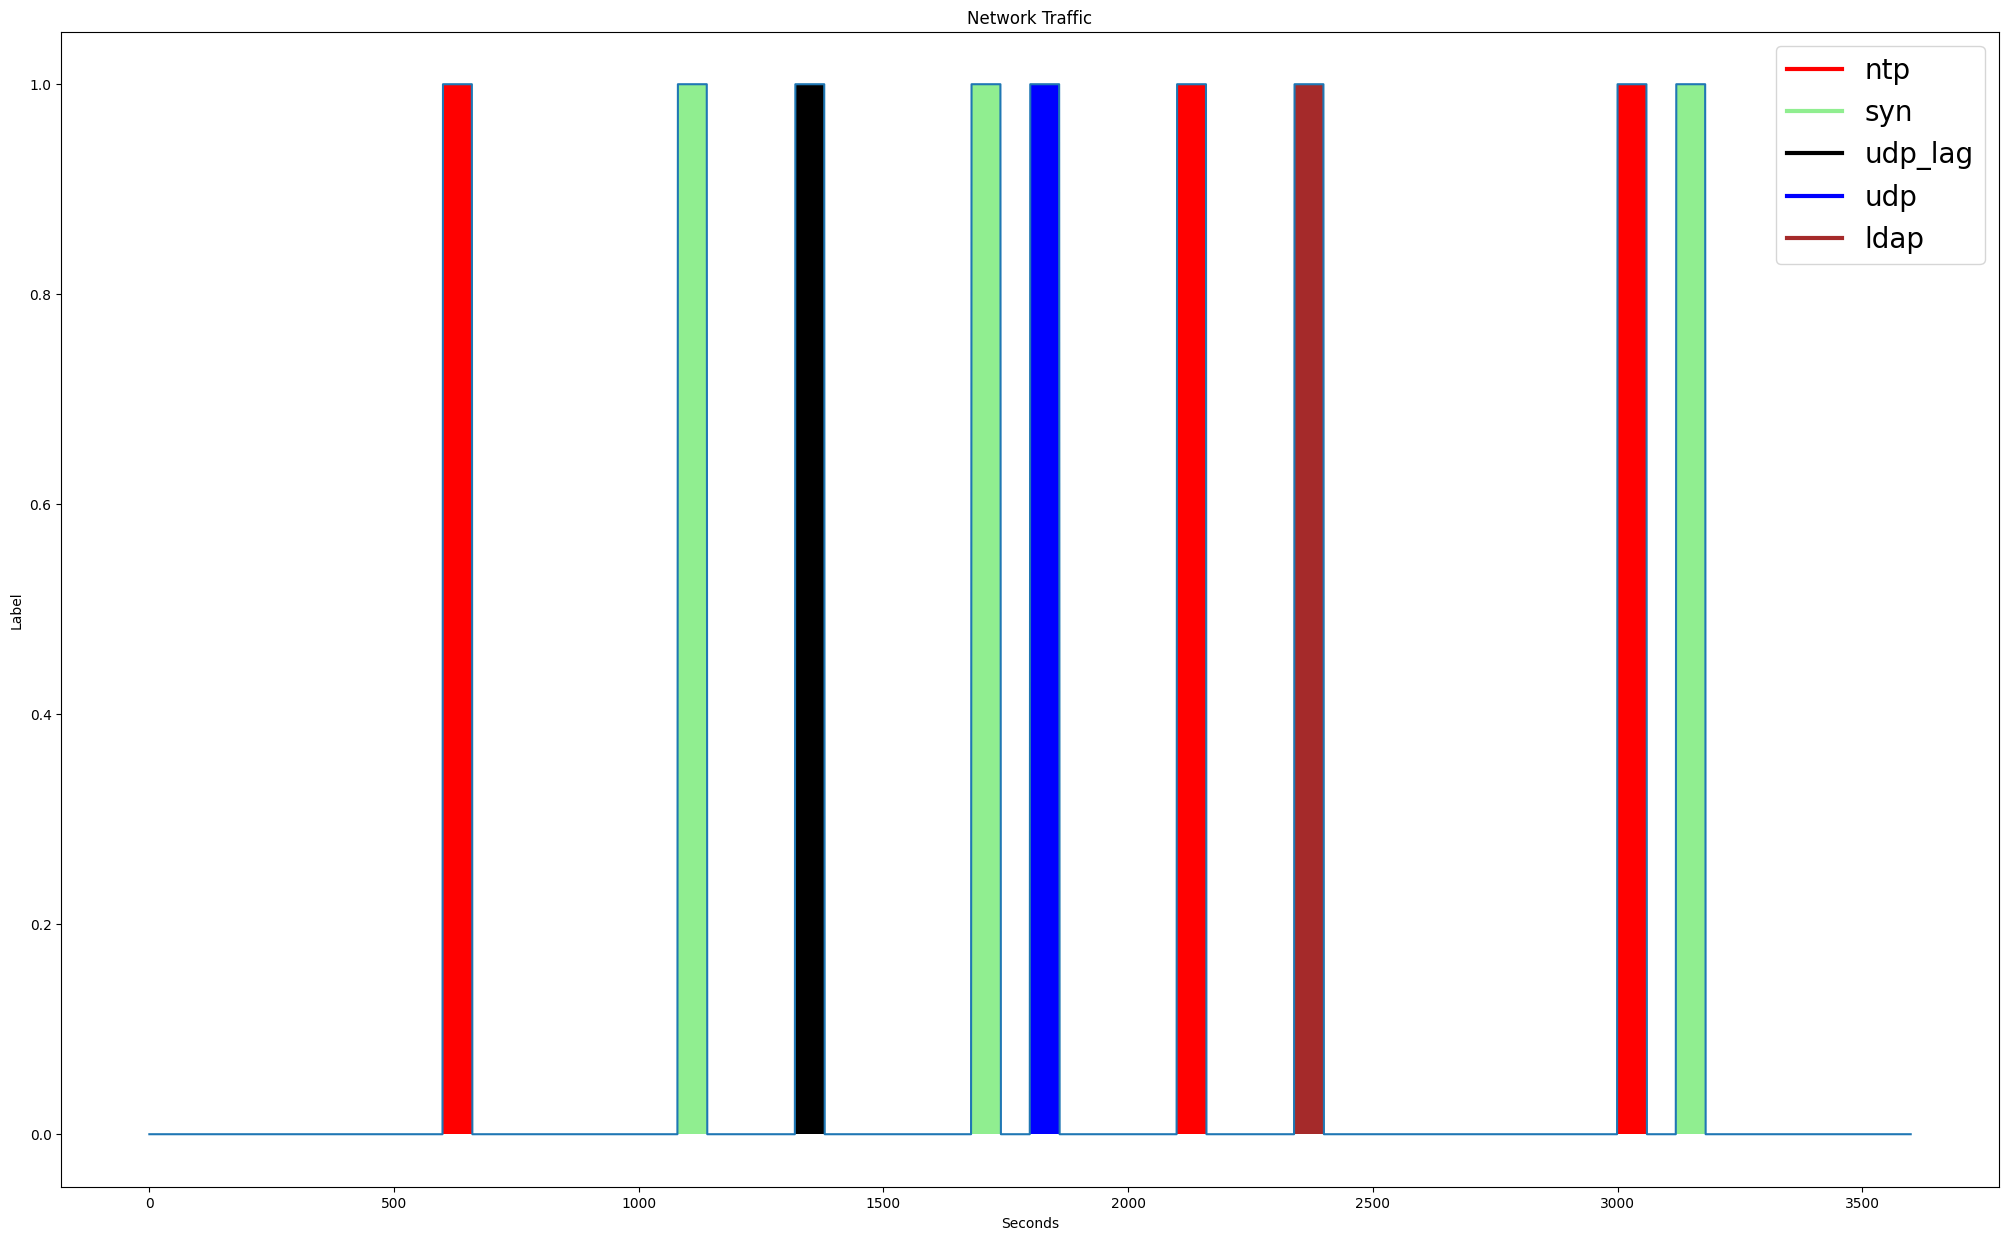

In [114]:
plot_ddos(mixed_attacks, [('ntp', 1, 10), ('syn', 1, 18),
                         ('udp_lag', 1, 22), ('syn', 1, 28),
                         ('udp', 1, 30), ('ntp', 1, 35),
                         ('ldap', 1, 39), ('ntp', 1, 50), ('syn', 1, 52)])

In [113]:
f1_score_list = []
MatrixProfileManager.global_df = mixed_attacks.copy()
for col in mixed_attacks.columns[1:-1]:
    threshold_MP_mixed = ThresholdMatrixProfile(pd.DataFrame(mixed_attacks[col]), window_size=10, threshold=2)
    cost, f1_score = threshold_MP_mixed.calculate_cost()
    f1_score_list.append((f1_score, col))
    
sorted(f1_score_list, key=lambda x:x[0], reverse=True)[:5]

[(0.6176980913823019, ' Bwd Packet Length Min'),
 (0.5547703180212014, 'Fwd PSH Flags'),
 (0.5547703180212014, ' RST Flag Count'),
 (0.41288782816229114, ' Fwd Packet Length Min'),
 (0.3628076572470374, ' Total Length of Bwd Packets')]

In [134]:
f1_score_list = []
MatrixProfileManager.global_df = mixed_attacks.copy()
for col in mixed_attacks.columns[1:-1]:
    isolation_MP_mixed = IsolationMatrixProfile(pd.DataFrame(mixed_attacks[col]),
                                                window_size=60, n_estimators=100, contamination='auto')
    _, f1_s = isolation_MP_mixed.calculate_cost()
    
    f1_score_list.append((f1_s, col))
    
sorted(f1_score_list, key=lambda x:x[0], reverse=True)[:5]

[(0.5933933933933935, ' Flow IAT Mean'),
 (0.5880938063740229, ' Fwd IAT Mean'),
 (0.5853080568720379, ' Flow IAT Std'),
 (0.5740944017563117, ' Max Packet Length'),
 (0.5739320920043811, ' Packet Length Mean')]

In [127]:
from GeneticAlgorithmWrapper import *
from time import perf_counter

mixed_df = mixed_attacks.copy()
start_time = perf_counter()

MatrixProfileManager.global_df = mixed_df
GA = GeneticAlgo(mixed_df.iloc[:,1:].copy(), max_features=40,population_bag_size=20,
                 fitness=FitnessType.F1_Score,
                 mp_method=MPMethod.IsolationForest,  window_size=30, n_estimators = 100, contamination='auto')


pop_bag = GA.initialize_population()
generation_number = 1000

import random
f1_score_list = []
from tqdm import tqdm
for generation in tqdm(list(range(generation_number))):
    if (generation % 50 == 0):
        print(f"Generation {generation} is started!")
        
        res = GA.eval_fit_population(pop_bag)
        best_fit, _, best_solution, best_f1_score = GA.find_best(res).values()
        f1_score_list.append(best_f1_score)
        
        if (generation == 0):
            best_fit_global      = best_fit
            best_solution_global = best_solution
            best_f1_global       = best_f1_score
        else:
            if (best_f1_score >= best_f1_global):
                best_fit_global      = best_fit
                best_f1_global       = best_f1_score
                best_solution_global = best_solution
                print(f"best f1: {best_f1_global}")

        new_pop_bag = []
        for i in range(len(GA.population_bag)):
                # Pick 2 parents from the bag
            pA = GA.pick_one(pop_bag)
            pB = GA.pick_one(pop_bag)
            new_element = pA
            # Crossover the parents
            if random.random() <= 0.87:
                new_element = GA.crossover(pA, pB)
            #Mutate the child
            if random.random() <= 0.5:
                new_element = GA.mutation(new_element) 
            
            # Append the child to the bag
            new_pop_bag.append(new_element)
            # Set the new bag as the population bag
        pop_bag = GA.create_population(new_pop_bag)
        
    if (best_f1_global > 0.75):
        break
        
        
print("\n\n**** Generations Over ****\n")
print(f"Best Fitness: {best_fit_global}")
print(f"Best Solution: {best_solution_global}")
print(f"F1-Score: {max(f1_score_list)}")

end_time = perf_counter()
print(f"simulation longs {end_time - start_time} seconds")

Genetic Algorithm Process is ready to start


  0%|                                                                       | 0/1000 [00:00<?, ?it/s]

Generation 0 is started!


  0%|                                                             | 1/1000 [00:13<3:44:00, 13.45s/it]

Generation 50 is started!


  5%|███▏                                                          | 51/1000 [00:24<06:15,  2.53it/s]

Generation 100 is started!


 10%|██████▏                                                      | 101/1000 [00:35<04:26,  3.37it/s]

best f1: 0.5205479452054794
Generation 150 is started!


 15%|█████████▏                                                   | 151/1000 [00:45<03:37,  3.90it/s]

Generation 200 is started!


 20%|████████████▎                                                | 201/1000 [00:55<03:07,  4.26it/s]

best f1: 0.5220643231114435
Generation 250 is started!


 25%|███████████████▎                                             | 251/1000 [01:05<02:44,  4.54it/s]

Generation 300 is started!


 30%|██████████████████▎                                          | 301/1000 [01:14<02:23,  4.89it/s]

Generation 350 is started!


 35%|█████████████████████▍                                       | 351/1000 [01:21<02:01,  5.35it/s]

best f1: 0.5970772442588727
Generation 400 is started!


 40%|████████████████████████▍                                    | 401/1000 [01:29<01:43,  5.77it/s]

best f1: 0.6273164035689773
Generation 450 is started!


 45%|███████████████████████████▌                                 | 451/1000 [01:36<01:29,  6.16it/s]

Generation 500 is started!


 50%|██████████████████████████████▌                              | 501/1000 [01:42<01:17,  6.44it/s]

Generation 550 is started!


 55%|█████████████████████████████████▌                           | 551/1000 [01:49<01:06,  6.71it/s]

best f1: 0.6456375838926174
Generation 600 is started!


 60%|████████████████████████████████████▋                        | 601/1000 [01:56<00:57,  6.89it/s]

best f1: 0.7017064846416382
Generation 650 is started!


 65%|███████████████████████████████████████▋                     | 651/1000 [02:03<00:49,  7.00it/s]

Generation 700 is started!


 70%|██████████████████████████████████████████▊                  | 701/1000 [02:10<00:41,  7.15it/s]

Generation 750 is started!


 75%|█████████████████████████████████████████████▊               | 751/1000 [02:16<00:34,  7.19it/s]

Generation 800 is started!


 80%|████████████████████████████████████████████████▊            | 801/1000 [02:23<00:27,  7.30it/s]

Generation 850 is started!


 85%|███████████████████████████████████████████████████▉         | 851/1000 [02:30<00:20,  7.17it/s]

Generation 900 is started!


 90%|██████████████████████████████████████████████████████▉      | 901/1000 [02:37<00:13,  7.24it/s]

Generation 950 is started!


100%|████████████████████████████████████████████████████████████| 1000/1000 [02:44<00:00,  6.08it/s]



**** Generations Over ****

Best Fitness: 0
Best Solution: [10, 15]
F1-Score: 0.7017064846416382
simulation longs 164.56606810000085 seconds


In [133]:
print(mixed_attacks.columns[15], "\t", mixed_attacks.columns[10])

 Flow Packets/s 	 Bwd Packet Length Max


In [131]:
GA = GeneticAlgo(mixed_df.iloc[:,1:].copy(), max_features=40, population_bag_size=20,
                 fitness=FitnessType.F1_Score,
                 mp_method=MPMethod.ThresholdBase,  window_size=10)

MatrixProfileManager.global_df = mixed_df
pop_bag = GA.initialize_population()
generation_number = 1000
f1_score_list = []

import random
for generation in tqdm(range(generation_number)):
    if (generation % 50 == 0):
        print(f"Generation {generation} is started!")
        
        res = GA.eval_fit_population(pop_bag)
        best_fit, _, best_solution, best_f1_score = GA.find_best(res).values()
        f1_score_list.append(best_f1_score)
        
        if (generation == 0):
            best_fit_global      = best_fit
            best_solution_global = best_solution
            best_f1_global       = best_f1_score
        else:
            if (best_f1_score >= best_f1_global):
                best_fit_global      = best_fit
                best_f1_global       = best_f1_score
                best_solution_global = best_solution

        new_pop_bag = []
        for i in range(len(GA.population_bag)):
                # Pick 2 parents from the bag
            pA = GA.pick_one(pop_bag)
            pB = GA.pick_one(pop_bag)
            new_element = pA
            # Crossover the parents
            if random.random() <= 0.87:
                new_element = GA.crossover(pA, pB)
            #Mutate the child
            if random.random() <= 0.5:
                new_element = GA.mutation(new_element) 
            
            # Append the child to the bag
            new_pop_bag.append(new_element)
            # Set the new bag as the population bag
        pop_bag = GA.create_population(new_pop_bag)
        
print("\n\n**** Generations Over ****\n")
print(f"Best Fitness: {best_fit_global}")
print(f"Best Solution: {best_solution_global}")
print(f"F1-Score: {max(f1_score_list)}")

Genetic Algorithm Process is ready to start


  0%|                                                                       | 0/1000 [00:00<?, ?it/s]

Generation 0 is started!


  0%|                                                             | 1/1000 [00:07<2:01:34,  7.30s/it]

Generation 50 is started!


  5%|███▏                                                          | 51/1000 [00:13<03:34,  4.43it/s]

Generation 100 is started!


 10%|██████▏                                                      | 101/1000 [00:18<02:15,  6.62it/s]

Generation 150 is started!


 15%|█████████▏                                                   | 151/1000 [00:21<01:33,  9.04it/s]

Generation 200 is started!


 20%|████████████▎                                                | 201/1000 [00:24<01:11, 11.21it/s]

Generation 250 is started!


 25%|███████████████▎                                             | 251/1000 [00:27<00:57, 13.06it/s]

Generation 300 is started!


 30%|██████████████████▎                                          | 301/1000 [00:29<00:48, 14.40it/s]

Generation 350 is started!


 35%|█████████████████████▍                                       | 351/1000 [00:32<00:40, 15.95it/s]

Generation 400 is started!


 40%|████████████████████████▍                                    | 401/1000 [00:35<00:36, 16.24it/s]

Generation 450 is started!


 45%|███████████████████████████▌                                 | 451/1000 [00:38<00:34, 15.71it/s]

Generation 500 is started!


 50%|██████████████████████████████▌                              | 501/1000 [00:41<00:30, 16.45it/s]

Generation 550 is started!


 55%|█████████████████████████████████▌                           | 551/1000 [00:44<00:28, 15.77it/s]

Generation 600 is started!


 60%|████████████████████████████████████▋                        | 601/1000 [00:48<00:26, 15.11it/s]

Generation 650 is started!


 65%|███████████████████████████████████████▋                     | 651/1000 [00:52<00:24, 14.27it/s]

Generation 700 is started!


 70%|██████████████████████████████████████████▊                  | 701/1000 [00:56<00:20, 14.26it/s]

Generation 750 is started!


 75%|█████████████████████████████████████████████▊               | 751/1000 [00:59<00:17, 14.27it/s]

Generation 800 is started!


 80%|████████████████████████████████████████████████▊            | 801/1000 [01:03<00:14, 13.94it/s]

Generation 850 is started!


 85%|███████████████████████████████████████████████████▉         | 851/1000 [01:07<00:10, 13.80it/s]

Generation 900 is started!


 90%|██████████████████████████████████████████████████████▉      | 901/1000 [01:10<00:07, 13.41it/s]

Generation 950 is started!


100%|████████████████████████████████████████████████████████████| 1000/1000 [01:14<00:00, 13.37it/s]



**** Generations Over ****

Best Fitness: 0
Best Solution: [36, 11, 26, 12, 10]
F1-Score: 0.6176980913823019
